In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

In [2]:
import torch
import torch.nn.functional as F
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool
from second.pytorch.builder import (box_coder_builder, input_reader_builder,
                                    lr_scheduler_builder, optimizer_builder,
                                    second_builder)
from second.data.preprocess import merge_second_batch, merge_second_batch_multigpu
from second.pytorch.train import _worker_init_fn

from second.pytorch.train import example_convert_to_torch

from second.sphere.conv import init_depth_from_feature, depth_to_3D


## Read Config file

In [3]:
# config_path = "/home/yy/deeplearning/deeplearning/mypackages/second/configs/car.lite.nb.config"
config_path = "/home/gx/GitHub/depconv/second/configs/car.fhd.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.train_input_reader
model_cfg = config.model.second
# config_tool.change_detection_range(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")


## Build Network, Target Assigner and Voxel Generator

In [4]:
ckpt_path = "/home/gx/GitHub/depconv/second/depconv27/voxelnet-102080.tckpt"
net = build_network(model_cfg).to(device).eval()
net.load_state_dict(torch.load(ckpt_path))
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator

dataset = input_reader_builder.build(
    input_cfg,
    model_cfg,
    training=True,
    voxel_generator=voxel_generator,
    target_assigner=target_assigner,
    multi_gpu=False)

num_gpu=1
collate_fn= merge_second_batch
multi_gpu = False
dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=input_cfg.batch_size * num_gpu,
        shuffle=True,
#         num_workers=input_cfg.preprocess.num_workers * num_gpu,
        num_workers=1,
        pin_memory=False,
        collate_fn=collate_fn,
        worker_init_fn=_worker_init_fn,
        drop_last=not multi_gpu)

dense_shape =  [1, 63, 512, 512, 16]
[ 64 512 512]
rpn debug, final_num_filters =  192
rpn debug, num_cls =  2
rpn debug, num_anchor_per_loc =  2
feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)
feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)
remain number of infos: 3712


## Generate Anchors

In [5]:
grid_size = voxel_generator.grid_size
feature_map_size = grid_size[:2] // config_tool.get_downsample_factor(model_cfg)
feature_map_size = [*feature_map_size, 1][::-1]

anchors = target_assigner.generate_anchors(feature_map_size)["anchors"]
anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
anchors = anchors.view(1, -1, 7)

feautres size [1, 64, 64]
res = (1, 64, 64, 1, 2, 7)


## Read KITTI infos
you can load your custom point cloud.

In [6]:
info_path = input_cfg.dataset.kitti_info_path
root_path = Path(input_cfg.dataset.kitti_root_path)
with open(info_path, 'rb') as f:
    infos = pickle.load(f)

## Load Point Cloud, Generate Voxels

In [7]:
info = infos[564]
v_path = info["point_cloud"]['velodyne_path']
v_path = str(root_path / v_path)
points = np.fromfile(
    v_path, dtype=np.float32, count=-1).reshape([-1, 4])
# voxels, coords, num_points = voxel_generator.generate(points, max_voxels=90000)
# print(voxels.shape)
# add batch idx to coords
# coords = np.pad(coords, ((0, 0), (1, 0)), mode='constant', constant_values=0)
# voxels = torch.tensor(voxels, dtype=torch.float32, device=device)
# coords = torch.tensor(coords, dtype=torch.int32, device=device)
# num_points = torch.tensor(num_points, dtype=torch.int32, device=device)

## Detection

In [8]:
# example = {
#     "anchors": anchors,
#     "voxels": voxels,
#     "num_points": num_points,
#     "coordinates": coords,
# }
# pred = net(example)[0]
examples = []
loop_i = 0
for example in dataloader:
    loop_i += 1
    if loop_i > 10:
        break
    examples.append(example)
#     print(example)



WORKER 0 seed: 1589457963


/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: Invalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(float32, 3d, C), Tuple(slice<a:b>, list(int64), slice<a:b>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:
    All templates rejected with literals.
In definition 3:
    All templates rejected without literals.
In definition 4:
    All templates rejected with literals.
In definition 5:
    All templates rejected without literals.
In definition 6:
    All templates rejected with literals.
In definition 7:
    All templates rejected without literals.
In definition 8:
    All templates rejected with literals.
In definition 9:
    All templates rejected without literals.
In definition 

2 sum voxels =  [[251965.27   13955.18  -12797.165   5706.402]]
sum voxels =  [[251965.27   13955.18  -12797.165   5706.402]]
2 sum voxels =  [[346832.06    4489.42  -20966.7     3870.205]]
sum voxels =  [[346832.06    4489.42  -20966.7     3870.205]]
2 sum voxels =  [[269701.84    -6122.288  -13873.061    4260.0654]]
sum voxels =  [[269701.84    -6122.288  -13873.061    4260.0654]]


/home/gx/GitHub/depconv/second/core/geometry.py:272: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "points_in_convex_polygon_jit" failed type inference due to: Invalid use of Function(<built-in function getitem>) with argument(s) of type(s): (array(float32, 3d, C), Tuple(slice<a:b>, list(int64), slice<a:b>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:
    All templates rejected with literals.
In definition 3:
    All templates rejected without literals.
In definition 4:
    All templates rejected with literals.
In definition 5:
    All templates rejected without literals.
In definition 6:
    All templates rejected with literals.
In definition 7:
    All templates rejected without literals.
In definition 8:
    All templates rejected with literals.
In definition 9:
    All templates rejected without literals.
In definition 

2 sum voxels =  [[318115.53    20189.64   -17351.898    4238.6377]]
sum voxels =  [[318115.53    20189.64   -17351.898    4238.6377]]
2 sum voxels =  [[279528.6    -7843.112 -18000.15    5074.903]]
sum voxels =  [[279528.6    -7843.112 -18000.15    5074.903]]
2 sum voxels =  [[241436.8    -7316.172 -15898.503   3533.224]]
sum voxels =  [[241436.8    -7316.172 -15898.503   3533.224]]
2 sum voxels =  [[337778.4     30263.523  -17433.203    3110.6428]]
sum voxels =  [[337778.4     30263.523  -17433.203    3110.6428]]
2 sum voxels =  [[276664.7     32514.688  -16093.437    3709.2566]]
sum voxels =  [[276664.7     32514.688  -16093.437    3709.2566]]
2 sum voxels =  [[326891.66     7750.4614 -23172.104    3829.583 ]]
sum voxels =  [[326891.66     7750.4614 -23172.104    3829.583 ]]
2 sum voxels =  [[315596.34     2176.702  -19745.707    3739.2527]]
sum voxels =  [[315596.34     2176.702  -19745.707    3739.2527]]
2 sum voxels =  [[336972.25   -17630.14   -19683.564    3409.5364]]
sum voxels

In [9]:
examples[1]['voxels'].shape

(66309, 1, 4)

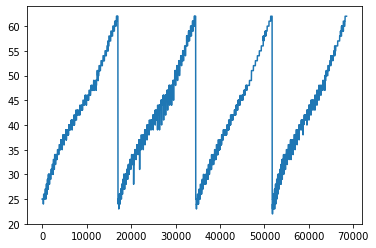

In [10]:
plt.plot(examples[4]['coordinates'][:,1])

In [11]:
example.keys()

dict_keys(['points', 'voxels', 'num_points', 'coordinates', 'num_voxels', 'metrics', 'calib', 'anchors', 'gt_names', 'labels', 'reg_targets', 'importance', 'metadata'])

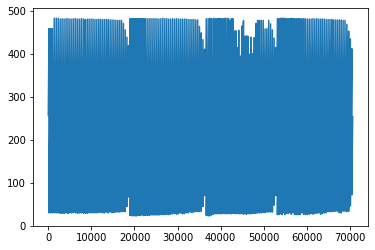

In [12]:
plt.plot(examples[0]['coordinates'][:,2])

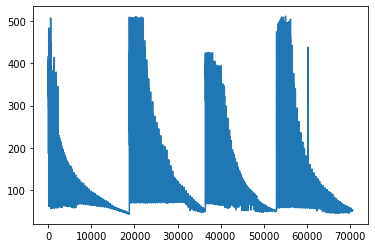

In [13]:
plt.plot(examples[0]['coordinates'][:,3])

In [14]:
sum(examples[0]['voxels'][ 615
                        ])


array([10.33 , -5.749,  0.533,  0.32 ], dtype=float32)

In [15]:
example = examples[5]
example = example_convert_to_torch(example, torch.float32)

with torch.no_grad():
    pred = net(example)


voxel_features shape:  torch.Size([63721, 4])
sparse_shape : [ 64 512 512]
NCDHW =  4 64 3 64 64


In [16]:
pred[3]['box3d_lidar']

tensor([], device='cuda:0', size=(0, 7))

In [17]:
boxes = example['anchors']
boxes
boxes.shape


torch.Size([4, 8192, 7])

In [18]:
boxes[0][1]

tensor([ 0.7857, -0.7857, -1.0000,  1.6000,  3.9000,  1.5600,  0.0000],
       device='cuda:0')

In [19]:
sum(example['points'])

array([1301686.4  ,   37366.086,  -81217.984,   15123.051], dtype=float32)

In [20]:
sum(example['voxels'])

tensor([[1113738.2500,   18692.7324,  -71466.2188,   13492.7305]],
       device='cuda:0')

In [21]:
example['anchors'][0][3027]

tensor([19.5541,  7.9571, -1.0000,  1.6000,  3.9000,  1.5600,  0.0000],
       device='cuda:0')

In [22]:
points

array([[69.166,  7.675,  2.562,  0.   ],
       [75.051,  9.167,  2.766,  0.   ],
       [74.998,  9.4  ,  2.765,  0.   ],
       ...,
       [ 3.657, -1.383, -1.707,  0.42 ],
       [ 3.659, -1.377, -1.707,  0.52 ],
       [ 3.914, -1.461, -1.832,  0.   ]], dtype=float32)

In [23]:
example["points"][0].shape

(4,)

In [24]:
res = voxel_generator.generate(
                points, 20000)
res['voxels'].shape

2 sum voxels =  [[-21153.322   27401.541  -12060.744    3981.9727]]
sum voxels =  [[-21153.322   27401.541  -12060.744    3981.9727]]


(20000, 1, 4)

## Simple Vis

In [25]:
# %config InlineBackend.figure_format = 'retina'


# boxes_lidar = boxes.detach().cpu().numpy()
# boxes_ldar = pred[1]['box3d_lidar']
# vis_voxel_size = [0.1, 0.1, 0.1]
# vis_point_range = [-50, -30, -3, 50, 30, 1]
# vis_point_range = [0, -40, -3, 80, 40, 1]
# bev_map = simplevis.point_to_vis_bev(example["points"], vis_voxel_size, vis_point_range)
# bev_map = simplevis.draw_box_in_bev(bev_map, vis_point_range, boxes_lidar, [0, 255, 0], 2)
# bev_map = simplevis.draw_box_in_bev(bev_map,vis_point_range, boxes_lidar[0][0:8000:80,:].cpu().numpy(), [0,255,0], 2)

In [26]:
# plt.imshow(bev_map)



In [27]:
# bev_map = simplevis.kitti_vis(example["points"][0], boxes[0].cpu().numpy())

In [28]:
# plt.imshow(bev_map)


In [29]:
example

{'points': array([[ 5.8415e+01,  2.6000e+00,  2.1860e+00,  0.0000e+00],
        [ 5.2750e+01,  2.7600e+00,  1.9950e+00,  1.7000e-01],
        [ 5.2705e+01,  2.9240e+00,  1.9940e+00,  0.0000e+00],
        ...,
        [ 6.4260e+00, -4.2000e-02, -1.6800e+00,  2.0000e-01],
        [ 6.4250e+00, -2.2000e-02, -1.6790e+00,  2.1000e-01],
        [ 6.4290e+00, -2.0000e-03, -1.6810e+00,  1.9000e-01]],
       dtype=float32),
 'voxels': tensor([[[ 5.8415e+01,  2.6000e+00,  2.1860e+00,  0.0000e+00]],
 
         [[ 5.2750e+01,  2.7600e+00,  1.9950e+00,  1.7000e-01]],
 
         [[ 5.2705e+01,  2.9240e+00,  1.9940e+00,  0.0000e+00]],
 
         ...,
 
         [[ 7.1960e+00, -5.7000e-02, -1.6780e+00,  0.0000e+00]],
 
         [[ 7.1540e+00, -3.4000e-02, -1.6680e+00,  0.0000e+00]],
 
         [[ 7.1850e+00, -1.2000e-02, -1.6760e+00,  0.0000e+00]]],
        device='cuda:0'),
 'num_points': tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0', dtype=torch.int32),
 'coordinates': tensor([[  0,  25, 270, 425

In [30]:
example = example_convert_to_torch(example, device=torch.device("cuda"))


voxels = example["voxels"]
num_points = example["num_points"]
coors = example["coordinates"]
batch_anchors = example["anchors"]
# feature = example["feature"]
batch_size_dev = batch_anchors.shape[0]
voxel_features = net.voxel_feature_extractor(voxels, num_points,
                                                      coors)
spatial_features = net.middle_feature_extractor(
            voxel_features, coors, batch_size_dev)
# vfeatures = net.voxel_feature_extractor(voxels, num_points, coors)
# preds_dict = net.network_forward(voxels, num_points, coors, batch_size_dev)
# spatial_features = net.feature_extractor(feature)

voxel_features shape:  torch.Size([63721, 4])
sparse_shape : [ 64 512 512]


/home/gx/GitHub/depconv/second/pytorch/train.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v, dtype=torch.float32, device=device).to(dtype)
/home/gx/GitHub/depconv/second/pytorch/train.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  v, dtype=torch.int32, device=device)
/home/gx/GitHub/depconv/second/pytorch/train.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  example_torch[k] = torch.tensor(v)
/home/gx/GitHub/depconv/second/pytorch/train.py:52: UserWarning: To copy construct from a tensor, it is recommended to use source

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.76 GiB total capacity; 294.59 MiB already allocated; 7.25 MiB free; 312.00 MiB reserved in total by PyTorch) (malloc at /opt/conda/conda-bld/pytorch_1579022060824/work/c10/cuda/CUDACachingAllocator.cpp:289)
frame #0: c10::Error::Error(c10::SourceLocation, std::string const&) + 0x47 (0x7ffb7e391627 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libc10.so)
frame #1: <unknown function> + 0x1ed15 (0x7ffb7e5d5d15 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #2: <unknown function> + 0x1ff2e (0x7ffb7e5d6f2e in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libc10_cuda.so)
frame #3: at::native::empty_cuda(c10::ArrayRef<long>, c10::TensorOptions const&, c10::optional<c10::MemoryFormat>) + 0x264 (0x7ffb85cd2c84 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #4: <unknown function> + 0x417c798 (0x7ffb84238798 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #5: <unknown function> + 0x1b0eaf7 (0x7ffb81bcaaf7 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #6: <unknown function> + 0x187f070 (0x7ffb8193b070 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #7: at::native::zeros(c10::ArrayRef<long>, c10::TensorOptions const&) + 0x25 (0x7ffb81944d55 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #8: <unknown function> + 0x1bc2933 (0x7ffb81c7e933 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #9: <unknown function> + 0x1c066c9 (0x7ffb81cc26c9 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #10: torch::zeros(c10::ArrayRef<long>, c10::TensorOptions const&) + 0x2d2 (0x7ffb54b5afe2 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/spconv/libspconv.so)
frame #11: at::Tensor spconv::indiceConv<float>(at::Tensor, at::Tensor, at::Tensor, at::Tensor, long, long, long) + 0x2e9 (0x7ffb54b6cc09 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/spconv/libspconv.so)
frame #12: c10::detail::wrap_kernel_functor_boxed<c10::detail::WrapRuntimeKernelFunctor_<at::Tensor (*)(at::Tensor, at::Tensor, at::Tensor, at::Tensor, long, long, long), at::Tensor, c10::guts::typelist::typelist<at::Tensor, at::Tensor, at::Tensor, at::Tensor, long, long, long> >, true, void>::call(c10::OperatorKernel*, std::vector<c10::IValue, std::allocator<c10::IValue> >*) + 0x150 (0x7ffb54b878c0 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/spconv/libspconv.so)
frame #13: <unknown function> + 0x2fa9fc9 (0x7ffb83065fc9 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #14: <unknown function> + 0x3ca7507 (0x7ffb83d63507 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch.so)
frame #15: <unknown function> + 0x6ea9a7 (0x7ffbb04149a7 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #16: <unknown function> + 0x6b4fe4 (0x7ffbb03defe4 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #17: <unknown function> + 0x28ba06 (0x7ffbaffb5a06 in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #18: _PyMethodDef_RawFastCallKeywords + 0x264 (0x558a368b5ab4 in /home/user/anaconda3/envs/depconv/bin/python)
frame #19: _PyCFunction_FastCallKeywords + 0x21 (0x558a368b5bd1 in /home/user/anaconda3/envs/depconv/bin/python)
frame #20: _PyEval_EvalFrameDefault + 0x4ecb (0x558a3691c57b in /home/user/anaconda3/envs/depconv/bin/python)
frame #21: _PyEval_EvalCodeWithName + 0x2f9 (0x558a36861389 in /home/user/anaconda3/envs/depconv/bin/python)
frame #22: _PyFunction_FastCallKeywords + 0x325 (0x558a368b5255 in /home/user/anaconda3/envs/depconv/bin/python)
frame #23: _PyEval_EvalFrameDefault + 0x4b39 (0x558a3691c1e9 in /home/user/anaconda3/envs/depconv/bin/python)
frame #24: _PyFunction_FastCallDict + 0x10b (0x558a368623fb in /home/user/anaconda3/envs/depconv/bin/python)
frame #25: THPFunction_apply(_object*, _object*) + 0xa0f (0x7ffbb03a0a3f in /home/user/anaconda3/envs/depconv/lib/python3.7/site-packages/torch/lib/libtorch_python.so)
frame #26: _PyMethodDef_RawFastCallKeywords + 0x1e0 (0x558a368b5a30 in /home/user/anaconda3/envs/depconv/bin/python)
frame #27: _PyCFunction_FastCallKeywords + 0x21 (0x558a368b5bd1 in /home/user/anaconda3/envs/depconv/bin/python)
frame #28: _PyEval_EvalFrameDefault + 0x4ecb (0x558a3691c57b in /home/user/anaconda3/envs/depconv/bin/python)
frame #29: _PyFunction_FastCallDict + 0x10b (0x558a368623fb in /home/user/anaconda3/envs/depconv/bin/python)
frame #30: _PyObject_Call_Prepend + 0x63 (0x558a36881a73 in /home/user/anaconda3/envs/depconv/bin/python)
frame #31: PyObject_Call + 0x6e (0x558a36873fde in /home/user/anaconda3/envs/depconv/bin/python)
frame #32: _PyEval_EvalFrameDefault + 0x1e9d (0x558a3691954d in /home/user/anaconda3/envs/depconv/bin/python)
frame #33: _PyEval_EvalCodeWithName + 0x2f9 (0x558a36861389 in /home/user/anaconda3/envs/depconv/bin/python)
frame #34: _PyFunction_FastCallDict + 0x1d5 (0x558a368624c5 in /home/user/anaconda3/envs/depconv/bin/python)
frame #35: _PyObject_Call_Prepend + 0x63 (0x558a36881a73 in /home/user/anaconda3/envs/depconv/bin/python)
frame #36: <unknown function> + 0x17d27a (0x558a368c927a in /home/user/anaconda3/envs/depconv/bin/python)
frame #37: _PyObject_FastCallKeywords + 0x48b (0x558a368ca2db in /home/user/anaconda3/envs/depconv/bin/python)
frame #38: _PyEval_EvalFrameDefault + 0x4a96 (0x558a3691c146 in /home/user/anaconda3/envs/depconv/bin/python)
frame #39: _PyFunction_FastCallDict + 0x10b (0x558a368623fb in /home/user/anaconda3/envs/depconv/bin/python)
frame #40: _PyObject_Call_Prepend + 0x63 (0x558a36881a73 in /home/user/anaconda3/envs/depconv/bin/python)
frame #41: PyObject_Call + 0x6e (0x558a36873fde in /home/user/anaconda3/envs/depconv/bin/python)
frame #42: _PyEval_EvalFrameDefault + 0x1e9d (0x558a3691954d in /home/user/anaconda3/envs/depconv/bin/python)
frame #43: _PyEval_EvalCodeWithName + 0x2f9 (0x558a36861389 in /home/user/anaconda3/envs/depconv/bin/python)
frame #44: _PyFunction_FastCallDict + 0x1d5 (0x558a368624c5 in /home/user/anaconda3/envs/depconv/bin/python)
frame #45: _PyObject_Call_Prepend + 0x63 (0x558a36881a73 in /home/user/anaconda3/envs/depconv/bin/python)
frame #46: <unknown function> + 0x17d27a (0x558a368c927a in /home/user/anaconda3/envs/depconv/bin/python)
frame #47: _PyObject_FastCallKeywords + 0x48b (0x558a368ca2db in /home/user/anaconda3/envs/depconv/bin/python)
frame #48: _PyEval_EvalFrameDefault + 0x5389 (0x558a3691ca39 in /home/user/anaconda3/envs/depconv/bin/python)
frame #49: _PyFunction_FastCallDict + 0x10b (0x558a368623fb in /home/user/anaconda3/envs/depconv/bin/python)
frame #50: _PyObject_Call_Prepend + 0x63 (0x558a36881a73 in /home/user/anaconda3/envs/depconv/bin/python)
frame #51: PyObject_Call + 0x6e (0x558a36873fde in /home/user/anaconda3/envs/depconv/bin/python)
frame #52: _PyEval_EvalFrameDefault + 0x1e9d (0x558a3691954d in /home/user/anaconda3/envs/depconv/bin/python)
frame #53: _PyEval_EvalCodeWithName + 0x2f9 (0x558a36861389 in /home/user/anaconda3/envs/depconv/bin/python)
frame #54: _PyFunction_FastCallDict + 0x1d5 (0x558a368624c5 in /home/user/anaconda3/envs/depconv/bin/python)
frame #55: _PyObject_Call_Prepend + 0x63 (0x558a36881a73 in /home/user/anaconda3/envs/depconv/bin/python)
frame #56: <unknown function> + 0x17d27a (0x558a368c927a in /home/user/anaconda3/envs/depconv/bin/python)
frame #57: _PyObject_FastCallKeywords + 0x48b (0x558a368ca2db in /home/user/anaconda3/envs/depconv/bin/python)
frame #58: _PyEval_EvalFrameDefault + 0x5389 (0x558a3691ca39 in /home/user/anaconda3/envs/depconv/bin/python)
frame #59: _PyEval_EvalCodeWithName + 0x2f9 (0x558a36861389 in /home/user/anaconda3/envs/depconv/bin/python)
frame #60: PyEval_EvalCodeEx + 0x44 (0x558a368622b4 in /home/user/anaconda3/envs/depconv/bin/python)
frame #61: PyEval_EvalCode + 0x1c (0x558a368622dc in /home/user/anaconda3/envs/depconv/bin/python)
frame #62: <unknown function> + 0x1db30d (0x558a3692730d in /home/user/anaconda3/envs/depconv/bin/python)
frame #63: _PyMethodDef_RawFastCallKeywords + 0xe9 (0x558a368b5939 in /home/user/anaconda3/envs/depconv/bin/python)


In [ ]:
spatial_features.shape

In [ ]:
examples[5]['voxels'].shape

In [ ]:
for i in range(128):
    plt.figure()
    plt.imshow(spatial_features[0][i].detach().cpu().numpy())

In [ ]:

if feature.dim() == 3:
    feature = feature.unsqueeze(0)
with torch.no_grad():
    depth = init_depth_from_feature(feature, 512)

depth = F.max_pool2d(depth, 3, padding=1, stride=1)

In [ ]:
depth.shape

In [ ]:
feature.shape

In [ ]:
# depth_to_3D(feature, depth.long(), D=256)

In [ ]:
plt.imshow(depth[0].detach().cpu().numpy())

In [ ]:
depth[0].detach().cpu().shape

In [ ]:
# depth[depth == 0 ] = 256

In [ ]:
def depth_bev(depth, R =500):
    """
    convert depth to bev
        depth: [H,W]
        to, 
    """
    H, W = depth.shape

    ret = np.zeros([R, W])
    for r in range(H):
        for i in range(W):
            d = int(depth[r][i])
            if d >= R:
                d = R-1
            ret[d][i] = 1
    return ret.T

plt.imshow(depth_bev(depth[0].detach().cpu().numpy()))

In [ ]:
depth1 = F.max_pool2d(depth, (2,1), padding=0, stride=(1,2)) / 2 
plt.imshow(depth_bev(depth1[0].detach().cpu().numpy(), 256))


In [ ]:
depth1

In [ ]:
depth2 = F.max_pool2d(depth1, (2,1), padding=0, stride=(1,2))/2
plt.imshow(depth_bev(depth2[0].detach().cpu().numpy(),  R=128))
print(depth2.shape)

In [ ]:
depth3 = F.avg_pool2d(depth2, (2,1), padding=0, stride=(1,2))/2
plt.imshow(depth_bev(depth3[0].detach().cpu().numpy(),  R=64))
print(depth3.shape)

In [ ]:
depth3.shape

In [ ]:
depth4 = F.max_pool2d(depth3, (2,1), padding=0, stride=(1,2)) /2 
plt.imshow(depth_bev(depth4[0].detach().cpu().numpy(), 32))
print(depth4.shape)

In [ ]:
depth5 = F.max_pool2d(depth4, (2,1), padding=(0,0), stride=(1,2)) /2 
plt.imshow(depth_bev(depth5[0].detach().cpu().numpy(), 16))
print(depth5.shape)

In [ ]:
bev = torch.tensor(depth_bev(depth[0].detach().cpu().numpy())).unsqueeze(0)
bev1 = F.max_pool2d(bev, 2, stride=2)
plt.imshow(bev1[0])

In [ ]:
bev2 = F.max_pool2d(bev1, 2, stride=2)
plt.imshow(bev2[0])

In [ ]:
bev3 = F.max_pool2d(bev2, 2, stride=2)
plt.imshow(bev3[0])

In [ ]:
bev4 = F.max_pool2d(bev3, 2, stride=2)
plt.imshow(bev4[0])

In [ ]:
bev5 = F.max_pool2d(bev4, 2, stride=2)
plt.imshow(bev5[0])

In [ ]:

# x = net.feature_extractor.conv1(feature, depth)
# x = net.feature_extractor.bn1(x)
# x = F.relu(x)

In [ ]:
# x.shape

In [ ]:
# plt.imshow(x[0][5].detach().cpu().numpy())

In [ ]:
depth_ = F.avg_pool2d(depth.float(), 2, padding=1, stride=(2,2)).long()

In [ ]:
plt.imshow(depth_[0].detach().cpu().numpy())

In [ ]:
for i in car_anchor_i:
    x = i % 64
    y = i // 64
    print(x,y)
    

In [ ]:
# example = examples[5]
# example = example_convert_to_torch(example, torch.float32)
feature = example['feature']
if feature.dim() == 3:
    feature = feature.unsqueeze(0)
with torch.no_grad():
    depth = init_depth_from_feature(feature, 512)
    
plt.figure(figsize = (25,25))
plt.imshow(depth[0].detach().cpu().numpy())

In [ ]:
example['metadata']

In [ ]:



car_anchor_i = []
for i, t in enumerate(example['reg_targets'][0]):
    if t.sum() > 0:
        print(i, t)
        car_anchor_i.append(i)
# car_anchor_i

car_anchors = example['anchors'][0][car_anchor_i]
car_anchors


bev_map = simplevis.kitti_vis(example['points'][0],
                              car_anchors.cpu().numpy()  )
plt.figure(figsize = (10,10))
plt.imshow(bev_map)